This is the notebook where I walk through the analysis workflow. 
utils.py contains all the important functions used here. The other
notebooks involve supplementary analysis or feature engineering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils

## load original dataframe

In [2]:
df = pd.read_csv('ssh-logs.csv')
# reorder columns
df = df[['time', 'src', 'client_version', 'fingerprint', 'user', 'password']]
df.head()

,time,src,client_version,fingerprint,user,password
0,2017-02-07T18:30:27-06:00,60.160.226.redacted,SSH-2.0-sshlib-0.1,NaN,root,12345
1,2017-02-07T19:11:17-06:00,177.42.196.redacted,SSH-2.0-Go,NaN,admin,smcadmin
2,2017-02-07T19:56:09-06:00,79.98.0.redacted,SSH-2.0-sshlib-0.1,NaN,root,password
3,2017-02-08T14:07:33-06:00,5.200.54.redacted,SSH-2.0-Go,NaN,support,password
4,2017-02-08T22:55:19-06:00,120.42.100.redacted,SSH-2.0-sshlib-0.1,NaN,root,111111


## manipulating the data

In [3]:
df.drop('fingerprint', axis=1, inplace=True)
df.time = pd.to_datetime(df.time, format='%Y-%m-%dT%H:%M:%S', utc=True)
print(len(df), len(df.src.unique()))
df.head()

10015 4510


,time,src,client_version,user,password
0,2017-02-08 00:30:27+00:00,60.160.226.redacted,SSH-2.0-sshlib-0.1,root,12345
1,2017-02-08 01:11:17+00:00,177.42.196.redacted,SSH-2.0-Go,admin,smcadmin
2,2017-02-08 01:56:09+00:00,79.98.0.redacted,SSH-2.0-sshlib-0.1,root,password
3,2017-02-08 20:07:33+00:00,5.200.54.redacted,SSH-2.0-Go,support,password
4,2017-02-09 04:55:19+00:00,120.42.100.redacted,SSH-2.0-sshlib-0.1,root,111111


### remove IP's with too few login attempts

In [4]:
thresh = 10

attack_counts = df.groupby('src').size()
ips_keep = attack_counts[attack_counts >= thresh].index
print(f'keeping {len(ips_keep)} out of {len(attack_counts)} ips')

df = df[np.isin(df.src, ips_keep)]
print('total number of attacks:', len(df))
df.head()

keeping 46 out of 4510 ips
total number of attacks: 4285


,time,src,client_version,user,password
407,2017-03-01 08:51:07+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao
408,2017-03-01 08:51:07+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao
409,2017-03-01 08:51:07+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao
410,2017-03-01 08:51:08+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao
411,2017-03-01 08:51:08+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao


### remove internal IP's

In [5]:
msk = df.src.str.startswith('192.168.')
num_found = len(df[msk].src.unique())
df = df[~msk]
print(f'keeping {len(ips_keep) - num_found} out of {len(ips_keep)} ips')

keeping 45 out of 46 ips


### geocode IP addresses

In [6]:
df_geo = utils.load_df_geo()
df_geo.head()

,city,country
60.160.226.redacted,Kunming,CN
177.42.196.redacted,Salvador,BR
79.98.0.redacted,Cremona,IT
5.200.54.redacted,Saint Petersburg,RU
120.42.100.redacted,Xiamen,CN


In [7]:
df = df.join(df_geo, 'src')
df.head()

,time,src,client_version,user,password,city,country
407,2017-03-01 08:51:07+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao,Qingdao,CN
408,2017-03-01 08:51:07+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao,Qingdao,CN
409,2017-03-01 08:51:07+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao,Qingdao,CN
410,2017-03-01 08:51:08+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao,Qingdao,CN
411,2017-03-01 08:51:08+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao,Qingdao,CN


### calculate inter-attack times

In [8]:
dt = utils.calculate_inter_attack_times(df)
df = df.join(dt)
df.head()

,time,src,client_version,user,password,city,country,dt
407,2017-03-01 08:51:07+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao,Qingdao,CN,NaN
408,2017-03-01 08:51:07+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao,Qingdao,CN,0.0
409,2017-03-01 08:51:07+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao,Qingdao,CN,0.0
410,2017-03-01 08:51:08+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao,Qingdao,CN,1.0
411,2017-03-01 08:51:08+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao,Qingdao,CN,0.0


## analyze most prevalent IPs

Text(0, 0.5, 'cmf')

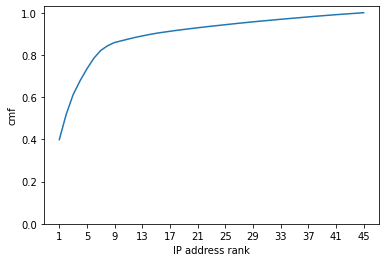

In [9]:
ips, cmf = utils.calculate_attack_count_cmf(df)
plt.plot(np.arange(1, len(ips)+1), cmf)
plt.xticks(np.arange(1, len(ips)+1, 4))
plt.ylim(0)
plt.xlabel('IP address rank')
plt.ylabel('cmf')

In [10]:
def print_top_prop(cmf, n_top):
    print(f'top {n_top} IPs account for {100*cmf[n_top-1]:.3f}% of attacks')

print_top_prop(cmf, 10)
print_top_prop(cmf, 20)

ips[:20]

top 10 IPs account for 86.710% of attacks
top 20 IPs account for 92.466% of attacks


['119.252.161.redacted',
 '121.18.238.redacted',
 '61.177.172.redacted',
 '221.194.44.redacted',
 '42.7.26.redacted',
 '221.194.47.redacted',
 '223.99.60.redacted',
 '218.65.30.redacted',
 '59.63.166.redacted',
 '117.14.105.redacted',
 '119.249.54.redacted',
 '113.195.145.redacted',
 '183.214.141.redacted',
 '164.132.19.redacted',
 '218.87.109.redacted',
 '115.238.94.redacted',
 '173.63.95.redacted',
 '117.164.152.redacted',
 '117.10.110.redacted',
 '46.173.214.redacted']

## grouping IPs into bots

### bot 1
- Poisson process with mean inter-attack time ~9 seconds.

IP: 119.252.161.redacted
origin: Tangerang, ID
client_versions: ['SSH-2.0-libssh2_1.7.0']
usernames: ['test', 'guest', 'user', 'oracle', 'mysql']
passwords: ['123456', 'test', '1234', '123', 'guest']


[(98.24, 9.394)]

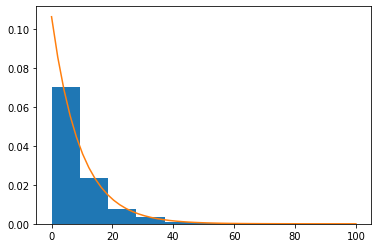

In [12]:
bot1 = ['119.252.161.redacted']

utils.print_text_features(df, bot1[0])
utils.plot_bot(df, bot1, t_max=100, fit=True, alpha=1)

### bot 2
- Constant inter-attack time of $\leq 1$ seconds

[89.2, 95.57, 92.63, 95.38, 94.12, 89.66, 96.0, 78.57, 91.67]

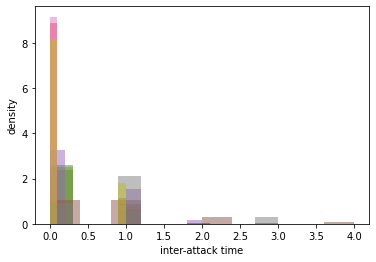

In [13]:
bot2 = [
    '61.177.172.redacted',
    '223.99.60.redacted',
    '218.65.30.redacted',
    '59.63.166.redacted',
    '113.195.145.redacted',
    '183.214.141.redacted',
    '218.87.109.redacted',
    '182.100.67.redacted',
    '118.212.135.redacted'
]

plt.xlabel('inter-attack time')
plt.ylabel('density')

utils.plot_bot(df, bot2, t_max=5)

### bot 3
- Poisson process with mean inter-attack time ~23 seconds

[(82.23, 23.473),
 (74.73, 24.224),
 (78.04, 23.479),
 (81.97, 22.2),
 (82.86, 23.621)]

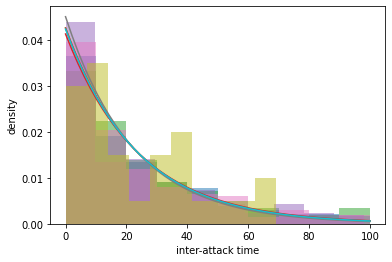

In [14]:
bot3 = [
    '121.18.238.redacted',
    '221.194.44.redacted',
    '221.194.47.redacted',
    '42.7.26.redacted',
    '119.249.54.redacted'
]

plt.xlabel('inter-attack time')
plt.ylabel('density')

utils.plot_bot(df, bot3, t_max=100, fit=True)

### bot 4

[91.43,
 92.86,
 95.24,
 95.0,
 94.74,
 94.44,
 82.35,
 82.35,
 87.5,
 93.75,
 80.0,
 93.33,
 86.67,
 92.86,
 84.62,
 92.31,
 92.31,
 84.62,
 91.67,
 91.67,
 91.67,
 83.33,
 81.82,
 81.82,
 81.82,
 80.0,
 90.0,
 90.0,
 90.0,
 20.0]

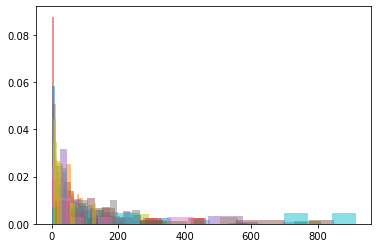

In [22]:
bot4 = [
    '117.14.105.redacted',
    '164.132.19.redacted',
    '115.238.94.redacted',
    '173.63.95.redacted',
    '117.164.152.redacted',
    '117.10.110.redacted',
    '46.173.214.redacted',
    '125.37.200.redacted',
    '170.250.69.redacted',
    '178.20.227.redacted',
    '198.24.146.redacted',
    '182.18.254.redacted',
    '111.162.230.redacted',
    '101.51.123.redacted',
    '99.14.31.redacted',
    '213.32.31.redacted',
    '193.70.89.redacted',
    '122.15.164.redacted',
    '83.136.165.redacted',
    '202.87.35.redacted',
    '222.85.224.redacted',
    '187.242.35.redacted',
    '177.229.59.redacted',
    '60.24.240.redacted',
    '164.132.109.redacted',
    '24.232.219.redacted',
    '136.25.162.redacted',
    '113.6.252.redacted',
    '93.125.42.redacted',
    '84.245.225.redacted'
]

utils.plot_bot(df, bot4, t_max=1000)

In [16]:
text_features = ['client_version', 'user', 'password']
categorical_features = ['country', 'city']

In [17]:
bots = [bot1, bot2, bot3, bot4]
for i,bot in enumerate(bots):
    for ip in bot:
        df.loc[df.src == ip, 'bot'] = i

df.head()

,time,src,client_version,user,password,city,country,dt,bot
407,2017-03-01 08:51:07+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao,Qingdao,CN,NaN,1.0
408,2017-03-01 08:51:07+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao,Qingdao,CN,0.0,1.0
409,2017-03-01 08:51:07+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao,Qingdao,CN,0.0,1.0
410,2017-03-01 08:51:08+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao,Qingdao,CN,1.0,1.0
411,2017-03-01 08:51:08+00:00,223.99.60.redacted,SSH-2.0-OpenSSH_6.2p2 Ubuntu-6,root,wubao,Qingdao,CN,0.0,1.0


In [19]:
mats = []
bot_idx = 3
alpha = .4

for _ in range(10):
    mat = utils.train_test(
        df, 
        bots, 
        bot_idx, 
        alpha, 
        text_features, 
        categorical_features)
    print(mat)
    mats += [mat / mat.sum()]

np.mean(mats, axis=0)


[[10  0]
 [ 8 10]]
[[10  0]
 [ 0 18]]
[[ 8  0]
 [ 0 18]]
[[ 8  0]
 [ 0 18]]
[[ 7  1]
 [ 0 18]]
[[ 8  0]
 [ 0 18]]
[[ 8  1]
 [15  3]]
[[ 9  1]
 [ 0 18]]
[[ 8  0]
 [ 0 18]]
[[ 7  1]
 [ 0 18]]


array([[0.31012414, 0.01496744],
       [0.08412698, 0.59078144]])